# **Introduction**

Welcome to the programming portion of assignment 3 of CS 4756/5756. In this assignment, you will implement several variations of Actor-Critic algorithms and compare their performances.

Concretely, you will:
* Implement the Advantage Actor-Critic (A2C) algorithm (Part 1)
* Implement the Deep Deterministic Policy Gradient (DDPG) algorithm (Part 2)
* CS5756 Only: Implement the Soft-Actor-Critic (SAC) algorithm (Part 3)

You will use the FetchReach-v4 environments for this assignment. Refer to the Gymnasium-Robotics website for more details about [this environment](https://robotics.farama.org/envs/fetch/).


Please read through the following paragraphs carefully.

**Getting Started:** You should complete this assignment on **[Google Colab](https://colab.research.google.com/)**.

**Evaluation:**
Your code will be tested for correctness and, for certain assignments, speed. For this particular assignment, performance results will not be harshly graded (although we provide approximate expected reward numbers, you are not expected to replicate them exactly). Please remember that all assignments should be completed individually.

**Academic Integrity:** We will be checking your code against other submissions in the class for logical redundancy. If you copy someone else’s code and submit it with minor changes, we will know. These cheat detectors are quite hard to fool, so please don’t try. We trust you all to submit your own work only; please don’t let us down. If you do, we will pursue the strongest consequences available to us.

**Getting Help:** The [Resources](https://www.cs.cornell.edu/courses/cs4756/2025sp/#resources) section on the course website is your friend! If you ever feel stuck in these projects, please feel free to avail yourself to office hours and Edstem! If you are unable to make any of the office hours listed, please let TAs know and we will be happy to assist. If you need a refresher for PyTorch, please see this [60 minute blitz](https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html)! For Numpy, please see the quickstart [here](https://numpy.org/doc/stable/user/quickstart.html) and full API [here](https://numpy.org/doc/stable/reference/).


# **Setup**

**Please run the cells below to install the necessary packages**.



In [2]:
import sys
USING_COLAB = 'google.colab' in sys.modules

if USING_COLAB:
  !apt-get -qq update
  !apt-get -qq install -y libosmesa6-dev libgl1-mesa-glx libglfw3 libgl1-mesa-dev libglew-dev patchelf
  !apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
else:
  !pip install torch torchvision torchaudio
  !pip install numpy
  !pip install tqdm
  !pip install opencv-python

!pip install matplotlib
!pip install -U mediapy
!pip install -U renderlab
!pip install -U "imageio<3.0"
!pip install stable-baselines3[extra]
!git clone https://github.com/Farama-Foundation/Gymnasium-Robotics.git
!pip install -e Gymnasium-Robotics
sys.path.append('/content/Gymnasium-Robotics')

W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Selecting previously unselected package libglx-dev:amd64.
(Reading database ... 126209 files and directories currently installed.)
Preparing to unpack .../00-libglx-dev_1.4.0-1_amd64.deb ...
Unpacking libglx-dev:amd64 (1.4.0-1) ...
Selecting previously unselected package libgl-dev:amd64.
Preparing to unpack .../01-libgl-dev_1.4.0-1_amd64.deb ...
Unpacking libgl-dev:amd64 (1.4.0-1) ...
Selecting previously unselected package libegl-dev:amd64.
Preparing to unpack .../02-libegl-dev_1.4.0-1_amd64.deb ...
Unpacking libegl-dev:amd64 (1.4.0-1) ...
Selecting previously unselected package libgl1-mesa-glx:amd64.
Preparing to unpack .../03-libgl1-mesa-glx_23.0.4-0ubuntu1~22.04.1_amd64.deb ...
Unpacking libgl1-mesa-glx:amd64 (23.0.4-0ubuntu1~22.04.1) ...
Selecting previously unselected package libgles1:amd64.
Pr

In [3]:
import os
# Mujoco GLEW Setup
try:
  if _mujoco_run_once:
    pass
except NameError:
  _mujoco_run_once = False
if not _mujoco_run_once:
  try:
    os.environ['LD_PRELOAD']=os.environ['LD_PRELOAD'] + ':/usr/lib/x86_64-linux-gnu/libGLEW.so'
  except KeyError:
    os.environ['LD_PRELOAD']='/usr/lib/x86_64-linux-gnu/libGLEW.so'
  # presetup so we don't see output on first env initialization
  _mujoco_run_once = True
  if USING_COLAB:
    NVIDIA_ICD_CONFIG_PATH = '/usr/share/glvnd/egl_vendor.d/10_nvidia.json'
    if not os.path.exists(NVIDIA_ICD_CONFIG_PATH):
      with open(NVIDIA_ICD_CONFIG_PATH, 'w') as f:
          f.write("""{
          "file_format_version" : "1.0.0",
          "ICD" : {
              "library_path" : "libEGL_nvidia.so.0"
          }
      }
      """)
  # Set environment variable to support EGL (off-screen) rendering
  %env MUJOCO_GL=egl

env: MUJOCO_GL=egl


# Import packages and initial seeding


In [4]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions as D
from stable_baselines3.common.buffers import ReplayBuffer
import torch.optim as optim
import gymnasium as gym
import gymnasium_robotics
import gymnasium.wrappers as wrappers
import random
import tqdm
import matplotlib.pyplot as plt
from torch.distributions import Categorical

In [5]:
seed = 695

# Setting the seed to ensure reproducability
def reseed(seed : int):
    torch.manual_seed(seed)
    random.seed(seed)
    np.random.seed(seed)

reseed(seed)

In [6]:
# In this block we define wrappers necessary to simplify the environment MDP
def wrap_reach_fixed_goal(env):
  g = np.array([1.486, 0.73, 0.681], dtype=np.float32)
  env.unwrapped._sample_goal = lambda: g
  return env

class FetchRewardWrapper(gym.Wrapper):
  def reset(self, *args, **kwargs):
    obs, info = self.env.reset(*args, **kwargs)
    self.prev_dist = np.linalg.norm(obs['achieved_goal'] - obs['desired_goal'])
    return obs, info

  def step(self, action):
    obs, reward, terminated, truncated, info = self.env.step(action)

    achieved_goal = obs['achieved_goal']
    desired_goal = obs['desired_goal']
    current_dist = np.linalg.norm(achieved_goal - desired_goal)
    reward = (self.prev_dist - current_dist) * 10
    self.prev_dist = current_dist
    terminated = terminated or info['is_success']
    return obs, reward, terminated, truncated, info

# Visualize Helper Function

Below, we provide the helper function `visualize` for your use. This function will create a visualization of the environment passed in the parameter `env`. If you are using Colab, calling this function will render the visualization within the notebook. If you are using your local machine, this function will instead save a video of the visualization to your current directory (rendering videos in Jupyter Notebooks is not widely supported outside of Colab).

In [7]:
def visualize(env : gym.Env, algorithm=None, video_name="test"):
    """Visualize a policy network for a given algorithm on a single episode

        Args:
            algorithm (PolicyGradient): Algorithm whose policy network will be rolled out for the episode. If
            no algorithm is passed in, a random policy will be visualized.
            video_name (str): Name for the mp4 file of the episode that will be saved (omit .mp4). Only used
            when running on local machine.
    """

    def get_action(obs):
        if not algorithm:
            return env.action_space.sample()
        else:
            return algorithm.compute_action(obs)

    if USING_COLAB:
        import renderlab as rl

        directory = './video'
        env = rl.RenderFrame(env, "output/")
        obs, info = env.reset()
        for i in range(500):
            action = get_action(obs)
            obs, reward, terminated, truncated, info = env.step(action)

            if terminated or truncated:
                break

        env.play()
    else:
        import cv2

        video = cv2.VideoWriter(f"{video_name}.mp4", cv2.VideoWriter_fourcc(*'mp4v'), 24, (600,400))
        obs = env.reset()
        for i in range(500):
            action = get_action(obs)
            obs, reward, terminated, truncated, info = env.step(action)

            if terminated or truncated:
                break

            im = env.render(mode='rgb_array')
            im = im[:,:,::-1]

            video.write(im)

        video.release()
        env.close()
        print(f"Video saved as {video_name}.mp4")

### `PolicyNet` class

Paste below your implementation of the PolicyNet class from A2. Recall:

The `PolicyNet` class should define a neural network that takes in a state and outputs a probability distribution over the action space. The network should have the following architecture:

- Input layer: a fully-connected layer with `state_dim` input nodes and `hidden_dim` output nodes, followed by a ReLU activation function.

- Output layer: a fully-connected layer with `hidden_dim` input nodes and `action_dim * 2` output nodes (first half for $\mu(s_t)$, second half for $\log(\sigma(s_t))$).


Finally, after the output layer, return a `torch.distributions.normal.Normal` object with the proper $\mu(s_t)$ and $\sigma(s_t)$.

[Documentation on `torch.distributions.normal.Normal`](https://pytorch.org/docs/stable/distributions.html#normal)

> You should use the `nn` module of PyTorch to define this network, and use `D.Normal` to construct the final return distribution.


In [8]:
class PolicyNet(nn.Module):
    def __init__(self, state_dim: int, action_dim: int, hidden_dim: int):
        """Policy network architecture for policy gradient algorithms.

        Args:
            state_dim (int): Dimension of the state space.
            action_dim (int): Dimension of the action space.
            hidden_dim (int): Dimension of the hidden layers.
        """
        super(PolicyNet, self).__init__()
        # TODO: Implement the policy network for the REINFORCE algorithm here
        self.input_layer = nn.Linear(state_dim, hidden_dim)
        self.output_layer = nn.Linear(hidden_dim, action_dim * 2)
        self.action_dim = action_dim


    def forward(self, state: torch.Tensor) -> D.Normal:
        """Forward pass of the policy network.

        Args:
            state (torch.Tensor): State of the environment. Shape (N, state_dim)
        Returns:
            action_dist (D.Normal): Normal distribution representing \pi(a_t | s_t)
        """
        # TODO: Implement the forward pass of the policy network here.
        x = torch.relu(self.input_layer(state))
        output = self.output_layer(x)

        mean, log_std = torch.split(output, self.action_dim, dim=-1)
        std = torch.exp(log_std)
        action_dist = D.Normal(mean, std)

        return action_dist

<>:18: DeprecationWarning: invalid escape sequence '\p'


## **Notes about Fetch Reach Environment**
The environment uses a Fetch Robot, which is a 7-DoF Mobile Manipulator.

The task is a *goal-reaching task*:
The observation space contains '`observation`' which includes the state of the robot in the environment, and '`desired_goal`' which specifies the xyz coordinate that the robot's gripper aims to reach.

See https://robotics.farama.org/envs/fetch/reach/ for more details.


If the goal is reached, `info['is_success']` will be set to 1, and this is an indication that we should terminate the rollout.


The reward is -1 per timestep spent in the environment without completing the task, with 50 steps being the limit (so -50 is the worst episode return).

> Note: For this assignment, we've modified the environment that it only has a fixed goal to reach, and has better reward shaping, since vanilla REINFORCE will produce very noisy gradients for complex markov chains.

**Run the cell below to create and visualize the environment:**

In [9]:
# Let's initialize the environment first
reseed(seed)
env = gym.make("FetchReach-v4", render_mode="rgb_array")
env = wrap_reach_fixed_goal(env)
env = FetchRewardWrapper(env)
env = wrappers.FilterObservation(env, ["desired_goal", "observation"])
env = wrappers.FlattenObservation(env)

In [10]:
visualize(env)

/usr/local/lib/python3.11/dist-packages/moviepy/config_defaults.py:1: DeprecationWarning: invalid escape sequence '\P'
  """
/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:294: DeprecationWarning: invalid escape sequence '\d'
  lines_video = [l for l in lines if ' Video: ' in l and re.search('\d+x\d+', l)]
  from scipy.ndimage.filters import sobel

  if event.key is 'enter':

  from pkg_resources import resource_stream, resource_exists

Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  declare_namespace(pkg)

Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  declare_namespace(pkg)

Implementing implicit namespace packages (as specified in 

Moviepy - Building video temp-{start}.mp4.
Moviepy - Writing video temp-{start}.mp4



Moviepy - Done !
Moviepy - video ready temp-{start}.mp4



### `PolicyGradient` class

Here, we implement a basic version of the `PolicyGradient` class from A2.

Recall the following methods (that you will be implementing for your algorithms).

- `compute_action(self, state)`: Method that selects an action based on the policy network.

- `compute_loss(self, episode, gamma)`: Method that computes the loss for a given episode.

- `update_policy(self, episodes, optimizer, gamma)`: Method that updates the policy network.

In [11]:
# No need to implement anything in this cell, just run it.

class PolicyGradient:
    def __init__(
      self,
      policy_net : PolicyNet
    ):
      """Default class for a policy gradient algorithm.

      Args:
          policy_net (PolicyNet): Policy network
      """
      self.policy_net = policy_net

    @property
    def device(self):
      return next(iter(self.policy_net.parameters())).device

    def to(self, device : str | torch.device):
      self.policy_net.to(device)
      return self

    def compute_action(self, state : np.ndarray) -> np.ndarray:
        raise NotImplementedError("Make sure you implemented compute_action()!")

    def compute_loss(
      self,
      episode : list[tuple[
          np.ndarray, np.ndarray, float
      ]],
      gamma : float
    ) -> torch.Tensor:
      raise NotImplementedError("Make sure you implemented compute_loss()!")

    def update_policy(self, episodes, optimizer, gamma):
      raise NotImplementedError("Make sure you implemented update_policy()!")

In [12]:
def collect_episode(env : gym.Env, policy : PolicyGradient | None = None, seed : int | None = None):
    """
    Run an episode of the environment and return the episode

    Returns:
        episode (list): List of tuples (state, action, reward, next_state, done, info)
    """
    state, info = env.reset(seed=seed)
    episode = []
    done = False
    while not done:
      if policy is not None:
        action = policy.compute_action(state)
      else:
        action = env.action_space.sample()
      next_state, reward, terminated, truncated, info = env.step(action)
      done = terminated or truncated or info['is_success']
      episode.append((state, action, reward, next_state, done, info))
      state = next_state
    return episode

def evaluate(env : gym.Env, policy : PolicyGradient | None = None, num_episodes = 100):
    """Evaluate the policy network by running multiple episodes.

    Args:
        env (gym.Env): Environment to evaluate the policy network on
        policy (PolicyGradient): Policy network to evaluate
        num_episodes (int): Number of episodes to run

    Returns:
        average_reward (float): Average total reward per episode
    """
    episode_rewards = []
    for i in range(num_episodes):
      episode = collect_episode(env, policy)
      episode_rewards.append(sum([reward for _, _, reward, _, _, _ in episode]))
    return np.mean(episode_rewards)

# Part 1: Advantage Actor-Critic

In this part of the assignment, we will implement a version of the Advantage Actor-Critic (A2C) algorithm. This algorithm is an extension to the REINFORCE algorithm, and it combines both value-based and policy-based methods. **See MACRL 11.8 for more information on Actor-Critic methods.**

## Overview

The A2C algorithm reduces the variance of the model by subtracting a baseline from the sum of rewards. This modifies our original objective function as follows:

$$ J(\theta) = \mathbb{E}_{\tau \sim \pi_{\theta}}[r(\tau) - b] $$

where $b$ is the baseline.

In A2C, there is both a policy network $\pi_{\theta}$ (actor network) and a value network $V_ϕ$ (critic network). The policy network is used to select actions, while the value network is used to estimate the value of a state. The value network will be used to compute the baseline $b$ in A2C.

Specifically, using $V_{\phi}(s_t)$ as the baseline, and using (discounted) reward-to-go in place of total reward (as done in part 2), A2C approximates $ \nabla_\theta J(\theta)$ as follows:

$$ \nabla_\theta J(\theta) \approx \frac{1}{N} \sum_{i=1}^{N}  \sum_{t=0}^{T-1} \nabla_\theta log \pi_\theta(a_{it}|s_{it}) \bigl(R_{it} - V_ϕ (s_{it}) \bigl) $$

This algorithm is called **Advantage** Actor-Critic because the quantity $R_t - V_ϕ (s_{t})$ is an approximation of what is known as the *advantage function* $A^{\pi_{\theta}}$:

$$A^{\pi_{\theta}}(s_t,a_t) = Q^{\pi_{\theta}}(s_t,a_t) - V^{\pi_{\theta}}(s_t) \approx R_t - V_ϕ (s_t)$$

where $Q^{\pi_{\theta}}(s_t,a_t)$ and $V^{\pi_{\theta}}(s_t)$ are the actual exact Q and value functions for ${\pi_{\theta}}$.

Defining $\tilde{A_t} = R_t - V_ϕ (s_t)$ to be the approximate advantage function, we have:

$$ \nabla_\theta J(\theta) \approx \frac{1}{N} \sum_{i=1}^{N}  \sum_{t=0}^{T-1} \nabla_\theta log \pi_\theta(a_{it}|s_{it}) \tilde{A_{it}}$$

For A2C, we have two loss functions: one for the policy network and one for the value network. The policy loss will be defined similarly to the loss in reward-to-go REINFORCE, replacing $R_t$ with $\tilde{A_t}$ and additionally taking the average loss within each episode rather than using total loss (as is commonly done in practice):

$$ L_{\text{policy}} = - \frac{1}{N}\sum_{i=1}^{N} \frac{1}{T}\sum_{t=0}^{T-1} \log \pi_{\theta}(a_{it}|s_{it}) \tilde{A_{it}} $$

The value loss will be the average (across episodes) mean squared error between the reward to go and the estimated value of the state. But note that we already defined the difference between reward to go and estimated value as the approximate advantage function. So we have:

$$ L_{\text{value}} = \frac{1}{N}\sum_{i=1}^{N} \frac{1}{T}\sum_{t=0}^{T} (R_{it} - V_{\phi}(s_{it}))^2 = \frac{1}{N}\sum_{i=1}^{N} \frac{1}{T}\sum_{t=0}^{T} \tilde{A_{it}}^2$$

## Instructions

You will need to implement the following:

1. `ValueNet` class - This class will define the value network used in the A2C algorithm.

2. `ActorCriticPolicyGradient` class - This class will define the A2C algorithm. It will be a modified version of the `PolicyGradient` class that includes the value network and the A2C loss functions.

Follow the instructions below to implement each of these components.

### `ValueNet` class

The `ValueNet` class should define a neural network that takes in a state and outputs an estimate of the value of that state. The network should have the following architecture:

- Input layer: a fully-connected layer with `state_dim` input nodes and `hidden_dim` output nodes, followed by a ReLU activation function.

- Output layer: a fully-connected layer with `hidden_dim` input nodes and 1 output node.

You should use the `nn` module of PyTorch to define this network.

In [13]:
class ValueNet(nn.Module):
    def __init__(self, state_dim: int, hidden_dim: int):
        """Value network for the Advantage Actor-Critic algorithm.

        Args:
            state_dim (int): Dimension of the state space.
            hidden_dim (int): Dimension of the hidden layers.
        """
        #TODO: Implement the ValueNet architecture.
        super(ValueNet, self).__init__()
        self.input_layer = nn.Linear(state_dim, hidden_dim)
        self.output_layer = nn.Linear(hidden_dim, 1)

    def forward(self, state: torch.Tensor):
        """Forward pass of the value network.

        Args:
            state (torch.Tensor): State of the environment.

        Returns:
            x (torch.Tensor): Estimated value of the state.
        """
        #TODO: Implement the ValueNet forward pass.
        x = torch.relu(self.input_layer(state))
        output = self.output_layer(x)
        return output

### `ActorCriticPolicyGradient` class

The `ActorCriticPolicyGradient` class should define the A2C algorithm.

The `ActorCriticPolicyGradient` class should override the following methods from `PolicyGradient`:

- `__init__(self, env, policy_net: PolicyNet, value_net: ValueNet)`: Constructor method that initializes the environment, policy network, and value network.

- `compute_action(self, state)`: Method that selects an action based on the policy network.

- `compute_loss(self, episode, gamma)`: Method that computes the two loss functions for the A2C algorithm.

- `update_policy(self, episodes, optimizer, value_optimizer, gamma)`: Method that updates the policy network and value network using a batch of episodes.

- `train(self, num_episodes, batch_size, gamma, lr)`: Method that trains the policy network and value network using the A2C algorithm.

In [23]:
class ActorCriticPolicyGradient(PolicyGradient):
    def __init__(self, policy_net, value_net):
        """A2C algorithm.

        Args:
            policy_net (PolicyNet): Policy network
            value_net (ValueNet): Value network
        """

        super().__init__(policy_net)
        self.policy_net = policy_net.to(self.device)
        self.value_net = value_net.to(self.device)

    def compute_action(self, state : np.ndarray) -> np.ndarray:
      """Select an action based on the policy network

      Args:
          state (np.ndarray): State of the environment

      Returns:
          action (np.ndarray): Action to take
      """
      # TODO: Implement the action selection here based on the policy network output probabilities
      # You also need to convert between numpy arrays and torch tensors
      # HINT: Use `torch.no_grad`
      with torch.no_grad():
          state = torch.from_numpy(state).type(torch.float32)

          # get distribution from policy_net
          action_dist = self.policy_net(state)
          # sample action
          action = action_dist.sample().numpy()
          return action


    def compute_loss(self, episode, gamma):
        """Compute the loss function for the A2C algorithm

        Args:
            episode (list): List of tuples (state, action, reward)

        Returns:
            policy_loss (torch.Tensor): Value of policy loss function
            value_loss (torch.Tensor): Value of value loss function
        """
        #TODO: Implement the A2C loss function.
        # TODO1: Extract states, actions and rewards from the episode.
        states, actions, rewards, _, _, _ = zip(*episode)
        states_tensor = [torch.from_numpy(state).float() for state in states]
        actions_tensor = [torch.from_numpy(action).float() for action in actions]

        # TODO2: Compute the reward-to-go.
        discounted_reward = []
        for t in range(len(rewards)):
          discounted_reward_t = 0
          for i, r in enumerate(rewards[t:]):
            # t' - t = i (since t' = t + i)
            discounted_reward_t += (gamma ** i) * r
          discounted_reward.append(discounted_reward_t)
        discounted_reward_tensor = torch.tensor(discounted_reward, dtype=torch.float32, requires_grad=True)

        # TODO3: Compute the advantages and log probabilities.
        stacked_states_tensor = torch.stack(states_tensor)
        values = self.value_net(stacked_states_tensor).squeeze()
        advantages = discounted_reward_tensor - values.detach()

        # advantages_tensor = torch.FloatTensor(advantages)

        # calculate log probabilities, from A2
        log_probs = []
        for state, action in zip(states_tensor, actions_tensor):
          state = state.unsqueeze(0)
          action = action.unsqueeze(0)

          # get distribution from policy
          distribution = self.policy_net(state)

          # Compute log probability
          log_prob = distribution.log_prob(action).sum(dim=-1, keepdim=True)
          log_probs.append(log_prob)

        stacked_log_probs = torch.cat(log_probs)

        # TODO4: Compute the policy and value function loss.
        policy_loss = -(stacked_log_probs * advantages).mean()
        # print((-(stacked_log_probs * advantages).sum()))
        value_loss = advantages.pow(2).mean()

        return policy_loss, value_loss

    def update_policy(self, episodes, optimizer, value_optimizer, gamma):
        """Update the policy network and value network using the batch of episodes

        Args:
            episodes (list): List of episodes
            optimizer (torch.optim): Optimizer for policy network
            value_optimizer (torch.optim): Optimizer for value network
            gamma (float): Discount factor
        """
        # TODO: Compute the loss function for each episode
        total_policy_loss = 0
        total_value_loss = 0

        for episode in episodes:
            policy_loss, value_loss = self.compute_loss(episode, gamma)
            total_policy_loss += policy_loss
            total_value_loss += value_loss

        # Compute average loss
        avg_policy_loss = total_policy_loss / len(episodes)
        avg_value_loss = total_value_loss / len(episodes)

        # Update policy network
        optimizer.zero_grad()
        avg_policy_loss.backward()
        optimizer.step()

        # Update value network
        value_optimizer.zero_grad()
        avg_value_loss.backward()
        value_optimizer.step()

        return avg_policy_loss.item(), avg_value_loss.item()

    def train(self, env: gym.Env, num_iterations: int, batch_size: int, gamma: float, lr: float) -> None:
      """Train the policy and value networks using the A2C algorithm.

      Args:
          num_iterations (int): Number of training iterations.
          batch_size (int): Number of episodes per batch.
          gamma (float): Discount factor.
          lr (float): Learning rate.
      """
      # TODO: Implement the training loop for A2C. Very similar to all of your past training loops.
      self.policy_net.train()
      self.value_net.train()

      optimizer = optim.Adam(self.policy_net.parameters(), lr=lr)
      value_optimizer = optim.Adam(self.value_net.parameters(), lr=lr)

      losses = []

      progress = tqdm.trange(num_iterations)
      for i in progress:
        # Collect batch of episodes
        episodes = []

        for _ in range(batch_size):
            episode = collect_episode(env, self)
            episodes.append(episode)
        # Update policy and value networks
        policy_loss, value_loss = self.update_policy(episodes, optimizer, value_optimizer, gamma)

        losses.append((policy_loss, value_loss))
        progress.set_postfix(policy_loss=policy_loss, value_loss=value_loss)

      return losses

Now that you have implemented A2C, it is time to train and evaluate a policy. Below, we provide training hyperparameters which you should use in your experiments. See the writeup for additional instructions on what metrics and figures you need to include in your submission.

* Expected Training Time (Colab CPU): 15 minutes
* Expected Episodic Reward: > 1.3

In [24]:
print("Pre-training average return", evaluate(env))

Pre-training average return -0.6676836479480399


In [25]:
# Feel free to use the space below to run experiments and create plots used in your writeup.
reseed(seed)
env.reset(seed=seed)
env.action_space.seed(seed)
env.observation_space.seed(seed)

policy_net_a2c = PolicyNet(env.observation_space.shape[-1], env.action_space.shape[-1], 128)
value_net = ValueNet(env.observation_space.shape[-1], 128)
a2c = ActorCriticPolicyGradient(policy_net_a2c, value_net)

device = "cpu"
if torch.cuda.is_available():
  device = "cuda"
elif torch.backends.mps.is_available():
  device = "mps"


a2c.to(device)
losses = a2c.train(env, num_iterations=300, batch_size=16, gamma=0.99, lr=7e-4)

print("Average reward:", evaluate(env, a2c, 10))

visualize(env, algorithm=a2c, video_name="a2c")

100%|██████████| 300/300 [06:39<00:00,  1.33s/it, policy_loss=2.76, value_loss=1.29]


Average reward: 1.7694532814797899
Moviepy - Building video temp-{start}.mp4.
Moviepy - Writing video temp-{start}.mp4



t:   0%|          | 0/6 [00:00<?, ?it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file output//1743039409.9339106.mp4, 691200 bytes wanted but 0 bytes read,at frame 5/6, at time 0.17/0.17 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+

                                                  

Moviepy - Done !
Moviepy - video ready temp-{start}.mp4


## Please submit two separate plots in your writeup, of the value and policy loss across training. As well, note your average reward.

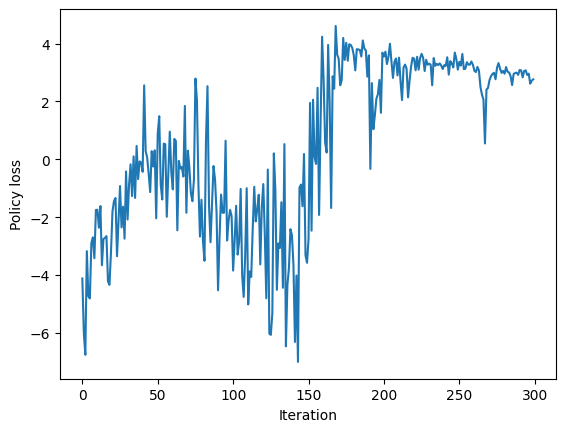

In [26]:
# Add your plotting code here, if you like.
policy_losses = [loss[0] for loss in losses]
iterations = range(len(losses))

plt.plot(iterations, policy_losses, label='Policy Loss')
plt.xlabel("Iteration")
plt.ylabel("Policy loss")
plt.show()

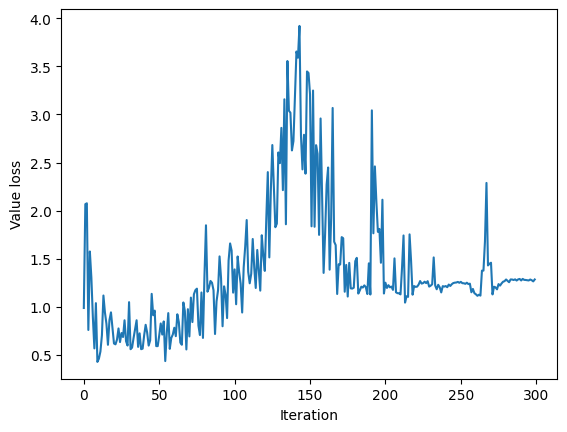

Average reward: 1.7855213437970086


In [27]:
# Add your plotting code here, if you like.
value_losses = [loss[1] for loss in losses]
iterations = range(len(losses))

plt.plot(iterations, value_losses, label='Value Loss')
plt.xlabel("Iteration")
plt.ylabel("Value loss")
plt.show()
print("Average reward:", evaluate(env, a2c, 10))

#Part 2: Deep Deterministic Policy Gradient (DDPG)

In this part of the assignment, we will implement a version of the Deep Deterministic Policy Gradient (DDPG) algorithm. Deep Deterministic Policy Gradient (DDPG) is an off-policy, actor-critic algorithm designed for continuous action spaces. It extends the ideas of Q-learning to the continuous domain by combining a deterministic policy (actor) with a Q-function approximator (critic).


DDPG learns a deterministic policy:

\begin{equation}
    \mu_{\theta}(s) \approx a
\end{equation}

where: $\mu_{\theta}(s)$ is the policy (actor) network parameterized by $\theta$,
$s$ is the current state,
$a$ is the deterministic action output.

This part requires three steps:
1. Implement `CriticNetwork()`
2. Implement `DeterministicActor()`
3. Implement `DDPGAgent()`

Below, we walk you through the steps.

### `CriticNetwork` class

The `CriticNetwork` class defines the "q-function" we have been discussing in classs; it should be a neural network that takes in a (state, action) pair, and outputs an estimate of the value of rolling out that (state, action) pair in the environment. The network should have the following architecture:

- Input layer: a fully-connected layer with `state_dim + action_dim` input nodes and `hidden_dim` output nodes, followed by a ReLU activation function.

- Intermediate layer: a fully connected `hidden_dim` input nodes and `hidden_dim` output nodes, followed by a ReLU activation function.

- Output layer: a fully-connected layer with `hidden_dim` input nodes and 1 output node.

You should use the `nn` module of PyTorch to define this network.

In [ ]:
class CriticNetwork(nn.Module):
    def __init__(self, obs_dim, act_dim, hidden_dim):
        super().__init__()
        #TODO: Implement the CriticNetwork architecture.
        self.input_layer = nn.Linear(obs_dim + act_dim, hidden_dim)
        self.hidden_layer = nn.Linear(hidden_dim, hidden_dim)
        self.output_layer = nn.Linear(hidden_dim, 1)

    def forward(self, x, a):
        #TODO: Implement the CriticNetwork forward pass.
        x = torch.cat([x, a], dim=-1)
        x = torch.relu(self.input_layer(x))
        x = torch.relu(self.hidden_layer(x))
        x = self.output_layer(x)
        return x

### `DeterministicActor` class

The `DeterministicActor` class should define a neural network that takes in a state, and deterministically outputs an action. The network should have the following architecture:

- Input layer: a fully-connected layer with `state_dim` input nodes and `hidden_dim` output nodes, followed by a ReLU activation function.

- Intermediate layer: a fully-connected layer with `hidden_dim` input nodes and `hidden_dim` output nodes, followed by a ReLU activation function.

- Output layer: a fully-connected layer with `hidden_dim` input nodes and `action_dim` output nodes.

In DDPG, the actor now directly outputs the action
𝑎, rather than a probability distribution over actions (like in stochastic policies). A fully connected neural network with linear output layers can produce arbitrarily small or large values, and so we need some way to constrain our output in the continuous control setting.

This is where we use the $\tanh$ squashing trick, where we apply $\tanh$ to the neural network's output to constrain it to the range $[-1, 1]$. This allows us to prevent outliers/arbitrarily large actions, but we still need to make sure the action is relevant for our environment.

We then want to scale the action to our environment. The actions in our environment are in the range $[\text{action_low}, \text{action_high}]$, which are both inputs to our Actor upon initialization. Can you think about how to define an "action bias" and "action scale" term, to transform our distribution from $[-1, 1]$ to $[\text{action_low}, \text{action_high}]$?

The final output of the forward method should be an action in the range $[\text{action_low}, \text{action_high}]$.

In [ ]:
class DeterministicActor(nn.Module):
    def __init__(self, obs_dim, act_dim, hidden_dim, action_high, action_low):
        super().__init__()
        #TODO: Implement the DeterministicActor architecture.
        self.input_layer = nn.Linear(obs_dim, hidden_dim)
        self.hidden_layer = nn.Linear(hidden_dim, hidden_dim)
        self.output_layer = nn.Linear(hidden_dim, act_dim)
        self.action_high = action_high
        self.action_low = action_low

    def forward(self, x):
        #TODO: Implement the DeterministicActor forward pass.
        # TODO1: passes the input through the two layers, each followed by a ReLU activation
        x = torch.relu(self.input_layer(x))
        x = torch.relu(self.hidden_layer(x))
        x = self.output_layer(x)
        # TODO2: scales the raw output within [-1,1]
        x = torch.tanh(x)
        # TODO3: rescale the raw outputs to match the environment action space.
        x = x * (self.action_high - self.action_low) / 2 + (self.action_high + self.action_low) / 2
        return x

### `DDPGAgent` class

The `DDPGAgent` class should define the DDPG algorithm. Recall that DDPG is an **off-policy algorithm**, meaning that we don't have to learn from temporally consistent episodes; instead, we sample batches of **transitions**, which consist of (state, next_state, action, reward, done, info), and then backpropagate the loss of our actor/critic to update the networks.

We do this by adding every transition we experience in the environment to a "replay buffer". This is the concept of "experience replay", and it is a widely used technique across reinforcement/robot learning algorithms ([read here if you want to learn more](https://datascience.stackexchange.com/questions/20535/what-is-experience-replay-and-what-are-its-benefits)). In this assignment, we use the Stable-Baselines3 replay buffer.

The basic structure of the `DDPGAgent` consists of:
- One `CriticNetwork()` and one target `CriticNetwork()`
- One `DeterministicActor()` and one target `DeterministicActor()`.

We use target networks to help stabilize training and reduce overestimation bias.

The formulation of DDPG is as follows:

Suppose we sampled a batch of transitions of form $(s, s', a, r, d, i)$:

We then want to compute the **target q-values** like so:

$$y(r, s', d) = r + \gamma (1-d)Q_{targ}(s', \mu_{\theta_{targ}}(s'))$$

The **critic** is then updated by one step of gradient descent like:

$$∇\frac{1}{|B|}∑_{(s, s', a, r, d) \in B}(Q(s, a)-y(r, s', d))^2$$

Next, we simply use queries of the critic to provide loss for the actor - intuitively, we want the actor to maximize the Q-function, and so we perform gradient **ascent** on the quantity:

$$∇\frac{1}{|B|}∑_{s \in B}Q(s, \mu_\theta(s))$$

Finally, we update the parameters of the target network according to a rate $\tau$; denoting the parameters of the critic by $\phi$ and the actor by $\theta$ gives the update step as:

$$\phi_{target} = (1-\tau)\phi_{target} + \tau\phi$$

$$\theta_{target} = (1-\tau)\theta_{target} + \tau\theta$$

We want you to implement the following methods:

- `train(self, num_iterations, batch_size)`: This is the method that trains the actor and critic in the DDPG algorithm. It should follow this basic format:
  - For each iteration in num_iterations, you should step through the environment, and add the transition to your replay buffer. Once you have accumulated batch_size transitions, call the `update_policy()` method every step.
  - Print out some useful training information, and track your losses.
  - **IMPORTANT**: When stepping through the environment, don't forget to set obs = next_obs when you are finished with the step!

- `compute_action(self, state)`: Since DDPG follows deterministic policy, we add Gaussian noise for exploration:
\begin{equation}
a = \mu_\theta(s) + \mathcal{N}
\end{equation}
where $\mathcal{N}$ is the Gaussian noise with mean of 0 and standard deviation of 0.1 (default).

- `compute_critic_loss(self, data)`: Method that computes the loss function for your critic network.

- `compute_actor_loss(self, data)`: Method that computes the loss function for your actor network. We apply L2 regularization with `policy_pre_activation_weight` to the actor loss function to penalize large action values. The regularization is implemented for you, you will only need to compute the Q values for policy actions and compute the raw actor loss.


- `update_target_net(self)`: Method that performs the weighted target net update.

- `update_policy(self, batch_size)`: Method that updates the actor and critic using batch of transitions. It should follow this basic format:
  - Sample `batch_size` transitions from your replay buffer.
  - Call `compute_critic_loss(self, data)`, and update the critic network.
  - Call `compute_actor_loss(self, data)`, and update the actor network.
  - Perform the target network update.


**Important** Please do not deviate from the `DDPGAgent()` format/method structure, it makes it much easier for us to help you in office hours!

In [ ]:
class DDPGAgent():
    def __init__(self, env, gamma, tau, actor_lr, critic_lr, network_hidden_dim):

        # You should not have to change anything in the init() method, we provide this for your convenience.

        self.env = env
        self.device = "cuda" if torch.cuda.is_available() else "cpu"

        obs_dim = np.prod(self.env.observation_space.shape)
        act_dim = np.prod(self.env.action_space.shape)

        self.actor = DeterministicActor(
            obs_dim, act_dim, network_hidden_dim,
            torch.tensor(self.env.action_space.high, dtype=torch.float32, device=self.device),
            torch.tensor(self.env.action_space.low, dtype=torch.float32, device=self.device)
        ).to(self.device)
        self.actor_target = DeterministicActor(
            obs_dim, act_dim, network_hidden_dim,
            torch.tensor(self.env.action_space.high, dtype=torch.float32, device=self.device),
            torch.tensor(self.env.action_space.low, dtype=torch.float32, device=self.device)
        ).to(self.device)
        self.actor_target.load_state_dict(self.actor.state_dict())

        self.critic = CriticNetwork(obs_dim, act_dim, network_hidden_dim).to(self.device)
        self.critic_target = CriticNetwork(obs_dim, act_dim, network_hidden_dim).to(self.device)
        self.critic_target.load_state_dict(self.critic.state_dict())

        self.replay_buffer = ReplayBuffer(int(1e6), self.env.observation_space, self.env.action_space, self.device, handle_timeout_termination=False)

        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=critic_lr)
        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=actor_lr)

        self.tau = tau
        self.gamma = gamma

        self.policy_pre_activation_weight = 0.1
        self.min_q_value = -np.inf
        self.max_q_value = np.inf



    def compute_action(self, obs, noise_std=0.1):
      obs_tensor = torch.tensor(obs, dtype=torch.float32)

      # Set actor to evaluation mode
      self.actor.eval()

      with torch.no_grad():
        # TODO1: compute raw action
        action = self.actor(obs_tensor)

      # Set actor back to training mode
      self.actor.train()

      # TODO2: add Gaussian noise with mean 0 and provided noise_std
      noise = torch.randn_like(action) * noise_std
      noisy_action = action + noise
      # TODO3: return clipped action within environment's action space
      action_np = noisy_action.cpu().numpy()
      clipped_action = np.clip(
            action_np,
            self.env.action_space.low,
            self.env.action_space.high
      )

      return clipped_action

    def train(self, num_iterations, batch_size):
      # TODO: Implement DDPG training loop.

      # TODO1: Set up stepping through the environment, and adding transitions to replay buffer.
      # TODO2: Update the policy with batch size.
      # TODO3: Print out useful information and losses.


    def compute_critic_loss(self, data):
      # TODO: Compute critic loss function.
      # TODO1: compute target Q-value
      # TODO2: compute predicted Q-value
      # TODO3: return Critic Loss (MSE loss)
      return NotImplementedError()


    def compute_actor_loss(self, data):
      #this is implemented for you in case where pre-activation is needed
      if self.policy_pre_activation_weight > 0 and hasattr(self.actor, "forward_with_preactivations"):
          policy_actions, pre_tanh_value = self.actor.forward_with_preactivations(data.observations)
      else:
          #TODO: step 1: compute action

      # TODO: Step 2: compute Q-value

      # TODO: Step 3: compute raw policy loss (maximize Q-values means minimize...)

      #If pre-activation regularization is enabled, compute the penalty
      if self.policy_pre_activation_weight > 0 and hasattr(self.actor, "forward_with_preactivations"):
          pre_activation_policy_loss = ((pre_tanh_value**2).sum(dim=1).mean())
          policy_loss = policy_loss + pre_activation_policy_loss * self.policy_pre_activation_weight

      return policy_loss

    def update_target_net(self):
      # TODO: Implement target net updating.

    def update(self, batch_size):
      # TODO: Implement the update step for the networks.

Now that you have implemented DDPG, it is time to train and evaluate a policy. Below, we provide training hyperparameters which you should use in your experiments. See the writeup for additional instructions on what metrics and figures you need to include in your submission.

* Expected Training Time (Colab CPU): < 5 minutes
* Expected Episodic Reward: ~ 1.3

In [ ]:
reseed(seed)
env.reset(seed=seed)
env.action_space.seed(seed)
env.observation_space.seed(seed)

ddpg_agent = DDPGAgent(
    env=env,
    gamma=0.99,
    tau=0.003,
    actor_lr=5e-6,
    critic_lr=1e-5,
    network_hidden_dim=256
)

num_iterations = 3000
batch_size = 256
ddpg_agent.train(num_iterations=num_iterations, batch_size=batch_size)

average_reward = evaluate(env, ddpg_agent, 10)
print(f"Average reward after training: {average_reward:.2f}")
visualize(env, algorithm=ddpg_agent, video_name="ddpg")

## Please submit two separate plots in your writeup, of the value and policy loss across training. As well, note your average reward.

In [ ]:
# Feel free to use this space for plotting.

#(CS5756 ONLY) Part 3: Soft Actor Critic (SAC)

In this part of the assignment, we will implement a version of the Soft Actor Critic (SAC) algorithm. SAC is an off-policy, actor-critic algorithm designed for continuous action spaces. Unlike DDPG, SAC learns a **stochastic** policy and incorporates an **entropy** term in the objective function to encourage exploration. This helps SAC achieve better stability and sample efficiency.

This part requires three steps:
1. Implement `StochasticActor()`
3. Implement `SACAgent()`

Below, we walk you through the steps.

### `StochasticActor` class

The `StochasticActor` class should define a neural network that takes in a state, and outputs an action sampled stochastically from a distribution. The network should have the following architecture:

- Input layer: a fully-connected layer with `state_dim` input nodes and `hidden_dim` output nodes, followed by a ReLU activation function.

- Intermediate layer: a fully-connected layer with `hidden_dim` input nodes and `hidden_dim` output nodes, followed by a ReLU activation function.

- Output layer I: a fully-connected layer with `hidden_dim` input nodes and `action_dim` output nodes for $\mu(s_t)$.

- Output layer II: a fully-connected layer with `hidden_dim` input nodes and `action_dim` output nodes for $\log(\sigma(s_t))$).

We again use the $\tanh$ squashing trick from our DDPG implementation, where we apply $\tanh$ to the neural network's output to constrain it to the range $[-1, 1]$. In the forward function, we do two different things:

For output layer I, we simply output the mean.

For output layer II, we want to scale the `log_std` distribution from $[-1, 1]$ to $[\text{LOG_STD_MIN}, \text{LOG_STD_MAX}]$. Use similar tricks from your DDPG implementation.

For `sample_action_distribution(self, x)`, we sample an initial $x_t$ from a `torch.distributions.normal.Normal` object with the proper $\mu(s_t)$ and $\sigma(s_t)$. Then, we apply the $\tanh$ squashing + biasing trick to our action $y_t$ to get our action in the range $[\text{action_low}, \text{action_high}]$.

To compute the log probability of our action, we take the log probability of our `torch.distributions.normal.Normal` at the sampled $x_t$, and subtract a corrective factor of $\log(\text{action_scale} * (1 - y_t^2) + 10^{-6})$ to account for the change in probability density from our $\tanh$ squashing trick.

The `sample_action_distribution(self, x)` mmethod should then output the scaled output action $y_t$, and the corrected log probability.

In [ ]:
LOG_STD_MAX = 2
LOG_STD_MIN = -5
class StochasticActor(nn.Module):
    def __init__(self, obs_dim, act_dim, hidden_dim, action_high, action_low):
        super().__init__()
        # TODO: Implement the StochasticActor network architecture.

    def forward(self, x):
        # TODO: Implement the StochasticActor forward pass.
        return NotImplementedError()

    def sample_action_distribution(self, x):
        # TODO: Implement sampling from the action distribution.
        return NotImplementedError()

### `SACAgent` class

The `SACAgent` class should define the SAC algorithm. Recall that SAC is an **off-policy algorithm**, so it trains very similarly to DDPG.

The basic structure of the `SACAgent` consists of:
- TWO `CriticNetwork()` and TWO target `CriticNetwork()`
- One `StochasticActor()`.

We use two critic networks in SAC to help reduce overestimation bias.

The formulation of SAC is as follows:

Suppose we sampled a batch of transitions of form $(s, s', a, r, d, i)$:

We then want to compute the **target q-values** like so, denoting $a' \sim \mu_\theta(s')$:

$$y(r, s', d) = r + \gamma (1-d)[\min(Q_{targ, 1}(s', a'), Q_{targ, 2}(s', a')) - \alpha\log\pi_\theta(a'|s')]$$

where $\alpha$ is the temperature parameter.

The **critic** is then updated by one step of gradient descent like:

$$∇\frac{1}{|B|}∑_{(s, s', a, r, d) \in B}(Q(s, a)-y(r, s', d))^2$$

The actor is updated by computing a loss dependent on entropy (which encourages exploration) and the Q-value of the actions taken by the actor (denoting $a = \mu_\theta(s)$).

$$∇\frac{1}{|B|}∑_{s' \in B}[\alpha\log\pi_\theta(a'|s') - \min(Q_1(s', a'), Q_2(s', a'))]$$

Finally, we update the parameters of the target network according to a rate $\tau$; the update step is:

$$\theta_{target, 1} = (1-\tau)\theta_{target, 1} + \tau\theta_1$$
$$\theta_{target, 2} = (1-\tau)\theta_{target, 2} + \tau\theta_2$$

We want you to implement the following methods:

- `train(self, num_iterations, batch_size)`: This is the method that trains the actor and critic in the SAC algorithm. It should follow this basic format:
  - For each iteration in num_iterations, you should step through the environment, and add the transition to your replay buffer. Once you have accumulated batch_size transitions, call the `update_policy()` method every step.
  - Print out some useful training information, and track your losses.
  - **IMPORTANT**: When stepping through the environment, don't forget to set obs = next_obs when you are finished with the step!

- `compute_action(self, state)`: Compute the action using the `sample_action_distribution` method of the Actor.

- `compute_critic_loss(self, data)`: Method that computes the loss function for your critic networks.

- `compute_actor_loss(self, data)`: Method that computes the loss function for your actor network.

- `update_target_net(self)`: Method that performs the weighted target net update.

- `update_actor(self, loss)`: Take in a loss computed by `compute_actor_loss(self, data)`, and update the actor network.

- `update_actor(self, loss1, loss2)`: Take in losses computed by `compute_critic_loss(self, data)`, and update the critic networks.

- `update_policy(self, batch_size)`: Method that updates the actor and critic using batch of transitions. It should follow this basic format:
  - Sample `batch_size` transitions from your replay buffer.
  - Call `update_critic()`.
  - Call `update_actor()`.
  - Call `update_target_net()`.


**Important** Please do not deviate from the `SACAgent()` format/method structure, it makes it much easier for us to help you in office hours!

In [ ]:
class SACAgent():
    def __init__(self, env, gamma, tau, alpha, actor_lr, critic_lr, network_hidden_dim):

        # You should not have to change anything in the init() method, we provide it for your convenience.
        self.env = env
        self.device = "cpu" if not torch.cuda.is_available() else "cuda"

        obs_dim = np.prod(self.env.observation_space.shape)
        act_dim = np.prod(self.env.action_space.shape)

        self.actor = StochasticActor(obs_dim, act_dim, network_hidden_dim, self.env.action_space.high, self.env.action_space.low).to(self.device)
        self.critic1 = CriticNetwork(obs_dim, act_dim, network_hidden_dim).to(self.device)
        self.critic2 = CriticNetwork(obs_dim, act_dim, network_hidden_dim).to(self.device)
        self.critic1_target = CriticNetwork(obs_dim, act_dim, network_hidden_dim).to(self.device)
        self.critic2_target = CriticNetwork(obs_dim, act_dim, network_hidden_dim).to(self.device)
        self.critic1_target.load_state_dict(self.critic1.state_dict())
        self.critic2_target.load_state_dict(self.critic2.state_dict())

        self.replay_buffer = ReplayBuffer(int(1e6), self.env.observation_space, self.env.action_space, self.device, handle_timeout_termination=False)
        self.critic_optimizer = optim.Adam(list(self.critic1.parameters()) + list(self.critic2.parameters()), lr=critic_lr)
        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=actor_lr)
        self.alpha = alpha
        self.tau = tau
        self.gamma = gamma

    def compute_action(self, obs):
      # TODO: Implement action computation.
      return NotImplementedError()

    def train(self, num_iterations, batch_size):
      # TODO: Implement training loop.

    def compute_critic_loss(self, data):
      # TODO: Implement critic loss computation.
      return NotImplementedError()

    def compute_actor_loss(self, data):
      # TODO: Implement actor loss computation.
      return NotImplementedError()

    def update_critic(self, loss1, loss2):
      # TODO: Implement critic update step.

    def update_actor(self, loss):
      # TODO: Implement actor update step.

    def update_target_net(self):
      # TODO: Implement target update step.


    def update(self, step, num_iterations):
        # TODO: Implement general update step (which calls other methods). Don't forget to print/return some useful information here.

Now that you have implemented SAC, it is time to train and evaluate a policy. Below, we provide training hyperparameters which you should use in your experiments. See the writeup for additional instructions on what metrics and figures you need to include in your submission.

* Expected Training Time (Colab CPU): < 5 minutes
* Expected Episodic Reward: 1.6-1.7

In [ ]:
# Feel free to use the space below to run experiments and create plots used in your writeup.
reseed(seed)
env.reset(seed=seed)
env.action_space.seed(seed)
env.observation_space.seed(seed)

sac_agent = SACAgent(env=env, gamma=0.99, tau=0.005, alpha = 0.2, actor_lr=3e-4, critic_lr=1e-3, network_hidden_dim=256)

device = "cpu"
if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"

losses = sac_agent.train(5000, 256)

print("Average reward:", evaluate(env, sac_agent, 10))

visualize(env, algorithm=sac_agent, video_name="sac")

## Please submit two separate plots in your writeup, of the value and policy loss across training. As well, note your average reward.

In [ ]:
# Feel free to use this space for plotting.